In [ ]:
import numpy as np
import pandas
from neuroanalysis.data import TSeries
from neuroanalysis.test_pulse import PatchClampTestPulse
from neuroanalysis.neuronsim.model_cell import ModelCell
from neuroanalysis.units import pA, mV, MOhm, us, ms, pF

In [ ]:
model_cell = ModelCell()

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.close('all')
%matplotlib widget
# mpl.use('Qt5Agg')
import pyqtgraph as pg
%gui qt

In [19]:
def test_test_pulse():
    # Just test against a simple R/C circuit attached to a pipette
    model_cell.enable_mechs(['leak'])
    model_cell.recording_noise = False
    
    tp = create_test_pulse(pamp=-10*pA, mode='ic', r_access=100*MOhm)    
    check_analysis(tp, model_cell)


def create_test_pulse(start=5*ms, pdur=10*ms, pamp=-10*pA, mode='ic', dt=10*us, r_access=10*MOhm, noise=5*pA, cpip=0.5*pF, cmem=50*pF):
    # update patch pipette access resistance
    model_cell.clamp.ra = r_access
    model_cell.clamp.cpip = cpip
    model_cell.soma.cap = cmem
    
    # update noise amplitude
    model_cell.mechs['noise'].stdev = noise
    
    # make pulse array
    duration = start + pdur * 3
    pulse = np.zeros(int(duration / dt))
    pstart = int(start / dt)
    pstop = pstart + int(pdur / dt)
    pulse[pstart:pstop] = pamp
    
    # simulate response
    result = model_cell.test(TSeries(pulse, dt), mode)
    
    # generate a PatchClampTestPulse to test against
    tp = PatchClampTestPulse(result)
    for ch in tp.channels:
        tp[ch].t0 =0

    return tp


def expected_testpulse_values(cell):
    if cell.clamp.mode == 'ic':
        values = {
            'baseline_potential': model_cell.resting_potential(),
            'baseline_current': model_cell.clamp.holding['ic'],
            'access_resistance': model_cell.clamp.ra,
            'capacitance': model_cell.soma.cap,
        }
    else:
        values = {
            'baseline_potential': model_cell.clamp.holding['vc'],
            'baseline_current': model_cell.resting_current(),
            'access_resistance': model_cell.clamp.ra,
            'capacitance': model_cell.soma.cap,
        }
    values['input_resistance'] = model_cell.input_resistance()

    return values


def check_analysis(tp: PatchClampTestPulse, cell: ModelCell):
    measured = tp.analysis
    expected = expected_testpulse_values(cell)
    
    # how much error should we tolerate for each parameter?
    err_tolerance = {
        'baseline_potential': 0.01,
        'baseline_current': 0.01,
        'access_resistance': 0.3,
        'input_resistance': 0.1,
        'capacitance': 0.3,
    }
    
    for k, v1 in expected.items():
        v2 = measured[k]
        if v1 is None:
            assert v2 is None, f"Test pulse metric {k} expected None, got {v2}"
            continue
        elif v2 is None:
            raise ValueError(f"Test pulse metric missing: {k} expected {v1:g}")
        elif v2 == 0:
            err = abs(v1 - v2)
        else:
            err = abs((v1 - v2) / v2)
        if err > err_tolerance[k]:
            raise ValueError(
                f"Test pulse metric out of range: {k} expected {v1:g}, got {v2:g}  (err {err:g} > {err_tolerance[k]:g})")



In [ ]:
# Just test against a simple R/C circuit attached to a pipette
model_cell.enable_mechs(['leak', 'lgkfast', 'lgkslow', 'lgkna'])
model_cell.recording_noise = False

tp = create_test_pulse(pamp=-10*pA, mode='ic', r_access=10*MOhm)
tp._analyze()

name, units = ('pipette potential', 'V') if tp.clamp_mode == 'ic' else ('pipette current', 'A')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax in axes:
    ax.plot(tp['primary'].time_values, tp['primary'].data, label='primary')
    ax.plot(tp.initial_fit_trace.time_values, tp.initial_fit_trace.data, 'g', label='initial fit')
    ax.plot(tp.fit_trace.time_values, tp.fit_trace.data, 'r', label='final fit')
    ax.set_xlabel('time (s)')
    ax.set_ylabel(name + ' (' + units + ')')
    ax.legend()

# plot an expanded region near the pulse start
pstart = tp['primary'].t0 + tp.stimulus.start_time
axes[1].set_xlim(pstart - .1*ms, pstart + .3*ms)
axes[1].set_ylim(-.0755, -.0749)


# check_analysis(tp, model_cell)

# print("Vm %g mV    Rm %g MOhm" % (model_cell.resting_potential()*1000, model_cell.input_resistance()/1e6))

# # Have to test VC with very low access resistance
# tp = create_test_pulse(pamp=-10*mV, mode='vc', r_access=15*MOhm)
# tp.plot()

check_analysis(tp, model_cell)
print("Test passed")

df = pandas.DataFrame()
for k,v in expected_testpulse_values(model_cell).items():
    df[k] = [v, tp.analysis[k]]
# label df rows
df.index = ['IC expected', 'IC measured']
display(df)
df


In [ ]:
check_analysis(tp, model_cell)
print("Test passed")

(array([-5.12652542e-10,  1.00000000e-05,  5.00000000e-03]), array([[ 9.28505271e-22,  1.37963833e-17, -4.76284139e-26],
       [ 1.37963833e-17,  1.72043278e-12, -7.07353997e-22],
       [-4.76284139e-26, -7.07353997e-22,  2.44313732e-30]]))


,baseline_potential,baseline_current,access_resistance,capacitance,input_resistance
IC expected,-0.075,-4.331865e-14,1.000000e+07,1.000000e-11,5.998909e+08
IC measured,-0.075,-4.315473e-14,1.564777e+07,5.898797e-12,6.115075e+08


ValueError: Test pulse metric out of range: access_resistance expected 1e+07, got 1.56478e+07  (err 0.360931 > 0.3)

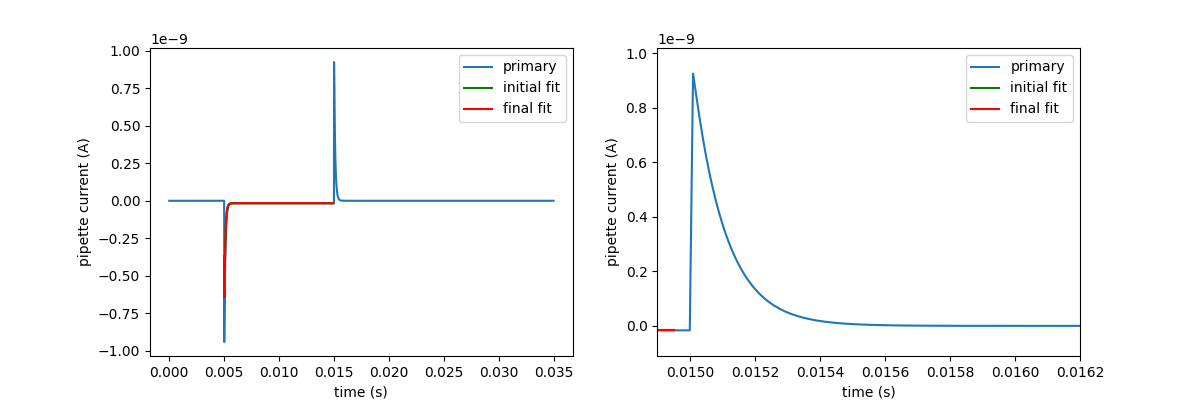

In [23]:
# Just test against a simple R/C circuit attached to a pipette
model_cell.enable_mechs(['leak', 'lgkfast', 'lgkslow', 'lgkna'])
model_cell.recording_noise = False

tp = create_test_pulse(pamp=-10*mV, mode='vc', r_access=10*MOhm, cpip=5*pF, cmem=10*pF)
tp._analyze()

name, units = ('pipette potential', 'V') if tp.clamp_mode == 'ic' else ('pipette current', 'A')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax in axes:
    ax.plot(tp['primary'].time_values, tp['primary'].data, label='primary')
    ax.plot(tp.initial_fit_trace.time_values, tp.initial_fit_trace.data, 'g', label='initial fit')
    ax.plot(tp.fit_trace.time_values, tp.fit_trace.data, 'r', label='final fit')
    ax.set_xlabel('time (s)')
    ax.set_ylabel(name + ' (' + units + ')')
    ax.legend()

# plot an expanded region near the pulse start
pstart = tp['primary'].t0 + tp.stimulus.start_time + tp.stimulus.duration
axes[1].set_xlim(pstart - .1*ms, pstart + 1.2*ms)
rgn = tp['primary'].time_slice(pstart - .1*ms, pstart + .3*ms)
mnmax = rgn.data.min(), rgn.data.max()
axes[1].set_ylim(mnmax[0] - 0.1*(mnmax[1]-mnmax[0]), mnmax[1] + 0.1*(mnmax[1]-mnmax[0]))


df = pandas.DataFrame()
for k,v in expected_testpulse_values(model_cell).items():
    df[k] = [v, tp.analysis[k]]
# label df rows
df.index = ['IC expected', 'IC measured']
display(df)

check_analysis(tp, model_cell)
print("Test passed")
